# Численное интегрирование

In [1]:
%matplotlib inline

import matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

In [2]:
import sys
sys.path.append('../numeric-core')
import numeric

Для приближённого вычисления интеграла используется формула Симпсона на равномерной сетке:

$$\int\limits_a^b f(x) dx \approx \frac{b-a}{6}{ \left( f(a) + 4 f\left(\frac{a+b}{2}\right) + f(b) \right)}$$

На одном сегменте пограшеность не превосходит

$$
\frac{(b - a)^5}{2880} \max_{x \in [a, b]} \left| f^{(4)}(x) \right|
$$

In [3]:
def estimate_error(derivative_4, derivative_5_roots, a, b, n):
    n = (n + 1) // 2
    
    error = 0.0
    x = np.linspace(a, b, n)
    
    for i in range(1, n):
        left = x[i - 1]
        right = x[i]
        
        max_val = max(np.abs(derivative_4(left)), np.abs(derivative_4(right)))
        for root in derivative_5_roots:
            if left < root < right:
                max_val = max(max_val, np.abs(derivative_4(root)))
        
        error += 1 / 2880 * np.power(right - left, 5) * max_val
    
    return error

In [4]:
def run(func, a, b, derivative_4=None, derivative_5_roots=None, value=None):
    def calc(n):
        return (
            numeric.integral_simpson(func, a, b, n),
            estimate_error(derivative_4, derivative_5_roots, a, b, n) if derivative_4 is not None else None
        )
    
    if value is None:
        value, eps = scipy.integrate.quad(func, a, b)
        
    x = np.unique(np.round(np.logspace(np.log10(1), 5)))
    arr = np.array([calc(int(2 * i + 1)) for i in x])
    
    values = np.full(len(x), value)
    absolute_error = np.abs(arr[:,0] - values)
    
    plt.plot(x, absolute_error, color='r', label='Simpson error')
    if derivative_4 is not None:
        plt.plot(x, arr[:,1], color='b', label='Estimated error')
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.legend(loc=3)

## Пример 1

$$f(x) = x^{1.5} \cdot \ln\left(\frac{1}{x}\right)$$

$$f^{(4)}(x) = 0.5625 \frac{\ln\left(\frac{1}{x}\right)}{x^{2.5}}$$
$$f^{(5)}(x) = 0 \text{ при } x = e^{2.5}$$

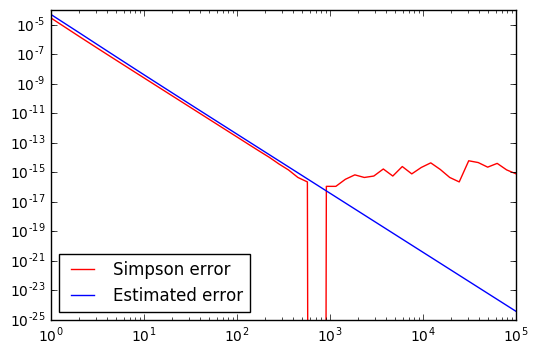

In [5]:
func = lambda x: np.power(x, 1.5) * np.log(1 / x)
derivative_4 = lambda x : 0.5625 * np.log(1 / x) / np.power(x, 1.5)

run(func, 1, 2,  derivative_4, [np.power(np.e, 2 / 5)])

(По оси $x$ отложено количество отрезков $n$, количество точек &mdash; $2n + 1$.)

## Пример 2

$$f_N(x) = \frac{\left\lfloor Nx \right\rfloor}{N} $$

Не будем аналитически оценивать погрешность разрывной функции.

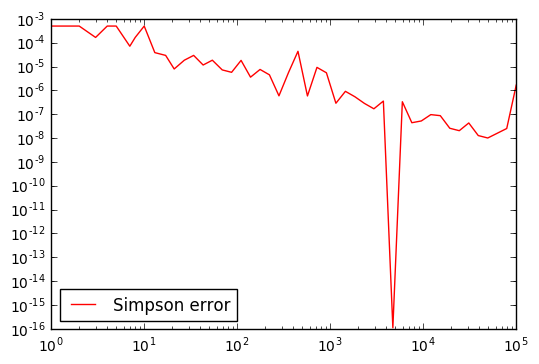

In [6]:
import scipy.optimize

N = 1e3
func = lambda x: np.floor(N * x) / N

run(func, 0, 1)

## Пример 3

$$f(x) = e^x \cdot sin(10x)$$
$$f(x)^{(4)} = -3960 e^x \cos(10 x)+9401 e^x \sin(10 x)$$
$$f(x)^{(5)} = 0 \text{ при } x = \frac{1}{5} \left(\pi k + \arctan\frac{49001 \pm 10201 \cdot \sqrt{101}}{90050}\right), k \in \mathbb{Z}$$

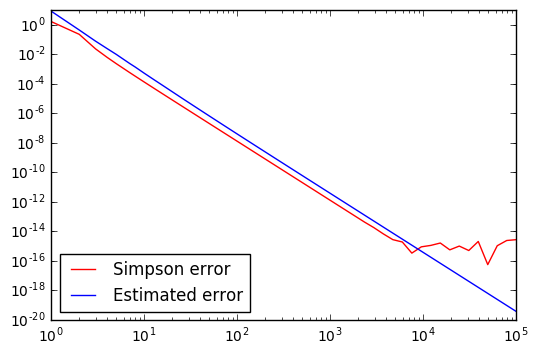

In [7]:
func = lambda x: np.power(np.e, x) * np.sin(10 * x)
derivative_4 =  lambda x : -3960 * np.power(np.e, x) * np.cos(10 * x) + 9401 * np.power(np.e, x) * np.sin(10 * x)

roots = []
for i in range(-10, 11):
    val1 = 0.2 * (np.pi * i + np.arctan2(49001 - 10201 * np.sqrt(101), 90050))
    val2 = 0.2 * (np.pi * i + np.arctan2(49001 + 10201 * np.sqrt(101), 90050))
    
    for val in (val1, val2):
        if 0 < val < 1:
            roots.append(val)

run(func, 0, 1, derivative_4, roots)

## Пример 4

$$f(x) = sin x \cdot e^{500 (x^2 + x)}$$
$$f^{(4)}(x) = e^{50 x (x+1)} ((20000 x (x+1) (5000 x (x+1)+2797)+7764401) \sin(x)+200 (2 x+1) (10000 x (x+1)+2799) \cos(x))$$
$$f^{(5)}(x) \ne 0 \text{ при } x \geq 0$$

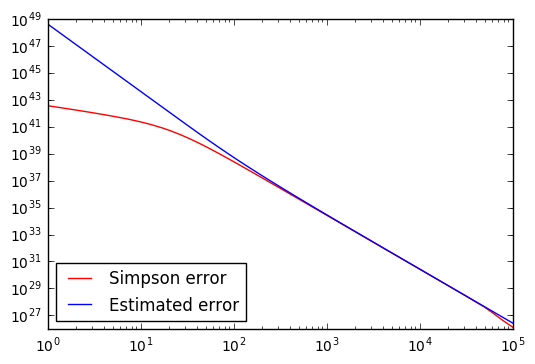

In [8]:
func = lambda x: np.sin(x) * np.power(np.e, 50 * (x**2 + x))
derivative_4 = lambda x : np.power(np.e, 50 * (x**2 + x)) * ((20000 * x * (x + 1) * (5000 * x * (x + 1) + 2797) + 7764401) * np.sin(x) + 200 * (2 * x+1) * (10000 * x * (x + 1) + 2799) * np.cos(x))

run(func, 0, 1, derivative_4, [])